In [52]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [53]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [54]:
import os

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Check what’s inside a folder
os.listdir('/content/drive/MyDrive/datasetsign_h264')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['fifth', 'first', 'five', 'fourteen']

In [55]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the dataset path
dataset_path = '/content/drive/MyDrive/datasetsign_h264'

# Example: list all files/folders in the dataset directory
import os
print("Files in dataset directory:", os.listdir(dataset_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in dataset directory: ['fifth', 'first', 'five', 'fourteen']


In [5]:
# #most important part1 if videos are not readable:
# import os
# from tqdm import tqdm

# input_dir = "/content/drive/MyDrive/datasetsign"
# output_dir = "/content/drive/MyDrive/datasetsign_h264"

# for root, dirs, files in os.walk(input_dir):
#     for file in tqdm(files):
#         if file.endswith(".mp4"):
#             os.makedirs(root.replace(input_dir, output_dir), exist_ok=True)
#             !ffmpeg -i "{os.path.join(root, file)}" \
#                    -c:v libx264 -preset fast -crf 23 \
#                    -c:a copy \
#                    "{os.path.join(root.replace(input_dir, output_dir), file)}" -y

In [56]:
# #most important part2: you can see all the videos are readable successfully
import cv2
import os

dataset_path = '/content/drive/MyDrive/datasetsign_h264'
all_classes = os.listdir(dataset_path)

for class_name in all_classes:
    class_path = os.path.join(dataset_path, class_name)
    video_files = os.listdir(class_path)

    print(f"\nClass: {class_name}")
    for video_file in video_files:
        video_path = os.path.join(class_path, video_file)
        print(f"Checking: {video_path}")

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ Failed to open: {video_path}")
            continue

        ret, frame = cap.read()
        if not ret:
            print(f"❌ Failed to read frame: {video_path}")
        else:
            print(f"✅ Successfully read frame. Shape: {frame.shape}")

        cap.release()


Class: fifth
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_2.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_3.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_4.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_5.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_8.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_10.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/fifth/fifth_11.mp4
✅ Successfully read frame. Shape: (720, 1280, 3)
Checking: /content/drive/MyDrive/datasetsign_h264/

[1] fourteen_10.mp4 | Success: True | Frame: (1080, 1920, 3)
[2] five_3.mp4 | Success: True | Frame: (1080, 1920, 3)
[3] first_4.mp4 | Success: True | Frame: (720, 1280, 3)
[4] fifth_13.mp4 | Success: True | Frame: (720, 1280, 3)


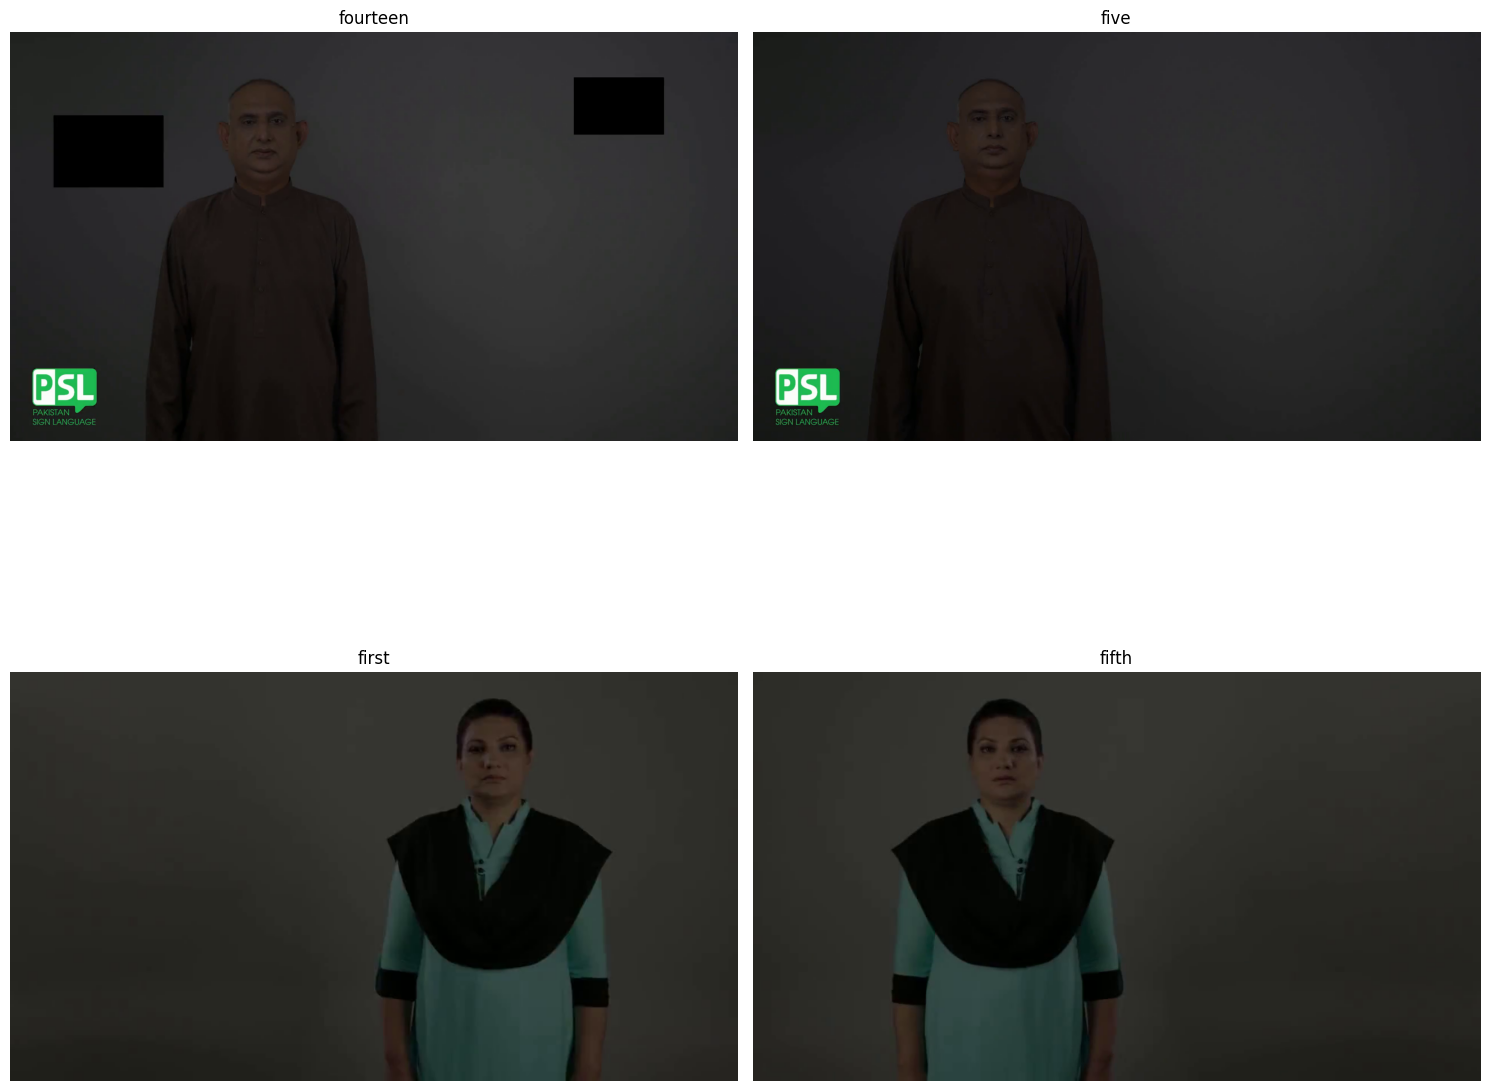

In [57]:
import os, cv2, random
import matplotlib.pyplot as plt

dataset_path='/content/drive/MyDrive/datasetsign_h264'
all_classes_names = os.listdir(dataset_path)
random_range = random.sample(range(len(all_classes_names)), 4)

plt.figure(figsize=(15, 15))

for counter, random_index in enumerate(random_range, 1):
    selected_class = all_classes_names[random_index]
    class_path = os.path.join(dataset_path, selected_class)
    video_list = os.listdir(class_path)
    selected_video = random.choice(video_list)
    video_path = os.path.join(class_path, selected_video)

    video_reader = cv2.VideoCapture(video_path)

    # Jump to frame 10
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, 10)
    success, frame = video_reader.read()
    video_reader.release()

    print(f"[{counter}] {selected_video} | Success: {success} | Frame: {None if frame is None else frame.shape}")

    if success and frame is not None:
        cv2.imwrite(f"/content/debug_frame_{counter}.jpg", frame)  # Save for visual check
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 2, counter)
        plt.imshow(frame_rgb)
        plt.title(selected_class)
        plt.axis('off')
    else:
        print(f"⚠️ Could not read frame from {video_path}")

plt.tight_layout()
plt.show()



In [58]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the  dataset.
DATASET_DIR = "/content/drive/MyDrive/datasetsign_h264"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['fifth', 'first', 'five', 'fourteen']

In [59]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    # Verify video can be opened
    if not video_reader.isOpened():
        print(f"⚠️ Could not open video: {video_path}")
        return None

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            print(f"⚠️ Could not read frame {frame_counter} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    # Return None if couldn't extract enough frames
    return frames_list if len(frames_list) == SEQUENCE_LENGTH else None

In [18]:
# def create_dataset():
#     '''
#     This function will extract the data of the selected classes and create the required dataset.
#     Returns:
#         features:          A list containing the extracted frames of the videos.
#         labels:            A list containing the indexes of the classes associated with the videos.
#         video_files_paths: A list containing the paths of the videos in the disk.
#     '''

#     # Declared Empty Lists to store the features, labels and video file path values.
#     features = []
#     labels = []
#     video_files_paths = []

#     # Iterating through all the classes mentioned in the classes list
#     for class_index, class_name in enumerate(CLASSES_LIST):

#         # Display the name of the class whose data is being extracted.
#         print(f'Extracting Data of Class: {class_name}')

#         # Get the list of video files present in the specific class name directory.
#         files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

#         # Iterate through all the files present in the files list.
#         for file_name in files_list:

#             # Get the complete video path.
#             video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

#             # Extract the frames of the video file.
#             frames = frames_extraction(video_file_path)

#             # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
#             # So ignore the vides having frames less than the SEQUENCE_LENGTH.
#             if len(frames) == SEQUENCE_LENGTH:

#                 # Append the data to their repective lists.
#                 features.append(frames)
#                 labels.append(class_index)
#                 video_files_paths.append(video_file_path)

#     # Converting the list to numpy arrays
#     features = np.asarray(features)
#     labels = np.array(labels)

#     # Return the frames, class index, and video file path.
#     return features, labels, video_files_paths

In [60]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'\nExtracting Data of Class: {class_name}')
        class_path = os.path.join(DATASET_DIR, class_name)

        if not os.path.exists(class_path):
            print(f"⚠️ Directory not found: {class_path}")
            continue

        files_list = os.listdir(class_path)

        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)
            print(f"Processing: {file_name}", end='\r')

            frames = frames_extraction(video_file_path)

            if frames is not None:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            else:
                print(f"⚠️ Skipped {file_name} (insufficient frames)")

    # Convert to numpy arrays only if we have data
    if features:
        features = np.asarray(features)
        labels = np.array(labels)
    else:
        print("❌ No valid videos found!")
        return None, None, None

    return features, labels, video_files_paths

In [61]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: fifth

Extracting Data of Class: first

Extracting Data of Class: five

Extracting Data of Class: fourteen


In [62]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [63]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [64]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [65]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


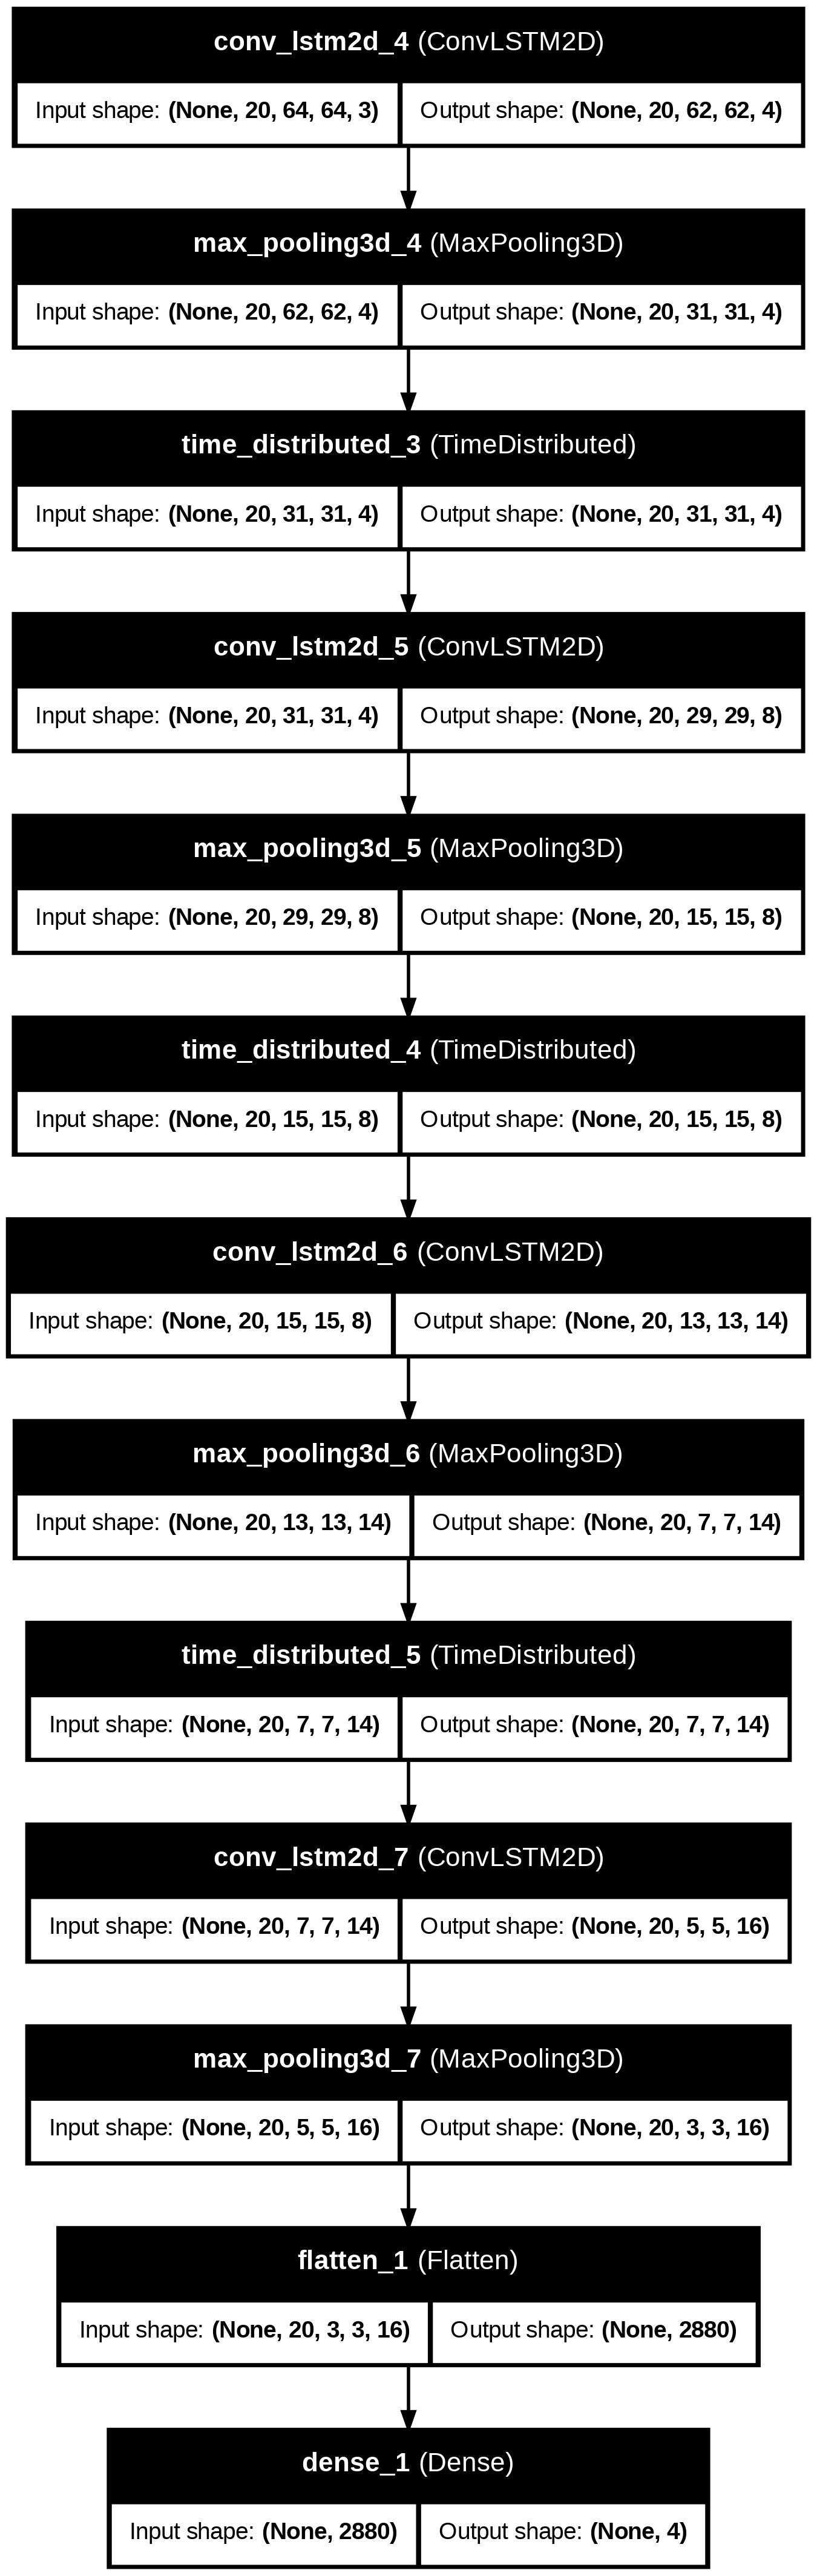

In [66]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [67]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4,shuffle = True, validation_split = 0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1858 - loss: 1.3934 - val_accuracy: 0.1000 - val_loss: 1.3926
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2675 - loss: 1.3644 - val_accuracy: 0.3000 - val_loss: 1.3810
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4054 - loss: 1.3142 - val_accuracy: 0.4000 - val_loss: 1.3217
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4986 - loss: 1.1934 - val_accuracy: 0.5000 - val_loss: 0.9229
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6552 - loss: 0.7874 - val_accuracy: 0.3000 - val_loss: 0.8086
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4293 - loss: 0.7667 - val_accuracy: 0.4000 - val_loss: 0.8122
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6430 - loss: 0.6713 - val_accuracy: 0.3000 - val_loss: 0.8601
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4595 - loss: 0.7450 - val_accuracy: 0.6000 - v

In [68]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0097


In [69]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# # Save your Model.
# convlstm_model.save(model_file_name)

# ✅ Define full path to save in Google Drive
save_path = f'/content/drive/MyDrive/{model_file_name}'

# ✅ Save the model
convlstm_model.save(save_path)

print(f'Model saved to: {save_path}')

Model saved to: /content/drive/MyDrive/convlstm_model___Date_Time_2025_07_16__10_11_00___Loss_0.00969666987657547___Accuracy_1.0.h5


In [70]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

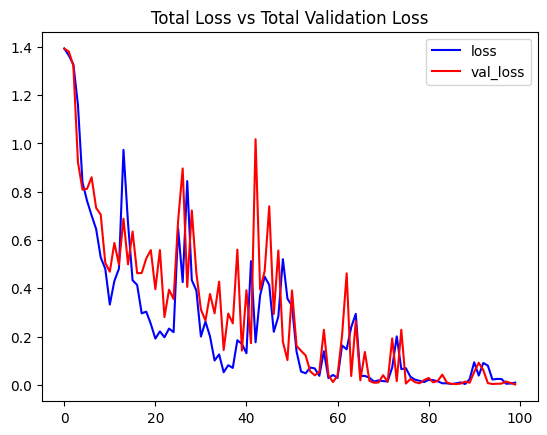

In [71]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

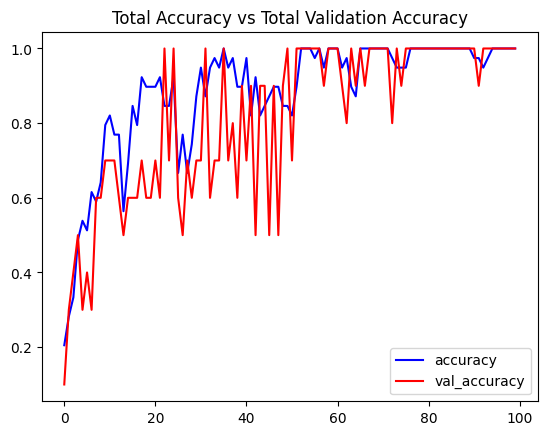

In [72]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [72]:
######making new folder####

In [78]:
import os
from google.colab import files
import shutil

# ✅ Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

# ✅ Define folder in Google Drive to save uploaded videos
drive_upload_folder = '/content/drive/MyDrive/uploaded_videos'

# ✅ Create the folder if it doesn't exist
if not os.path.exists(drive_upload_folder):
    os.makedirs(drive_upload_folder)
    print(f"📁 Created folder: {drive_upload_folder}")
else:
    print(f"📁 Folder already exists: {drive_upload_folder}")

# ✅ Upload video from local machine
uploaded_files = files.upload()

# ✅ Move uploaded files to the Google Drive folder
for file_name in uploaded_files:
    src_path = f'/content/{file_name}'  # Default upload location
    dst_path = os.path.join(drive_upload_folder, file_name)
    shutil.move(src_path, dst_path)
    print(f"✅ Saved to Google Drive: {dst_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Folder already exists: /content/drive/MyDrive/uploaded_videos


Saving 100_6.mp4 to 100_6.mp4
✅ Saved to Google Drive: /content/drive/MyDrive/uploaded_videos/100_6.mp4


In [80]:
import os
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import display
from tensorflow.keras.models import load_model

# ================================ CONFIGURATION ================================
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ['fifth', 'first', 'five', 'fourteen', 'output_videos']

# Paths
DATASET_PATH = '/content/drive/MyDrive/datasetsign_h264'
UPLOAD_PATH = '/content/drive/MyDrive/uploaded_videos'

# ================================ MOUNT DRIVE AND LOAD MODEL ================================
from google.colab import drive
drive.mount('/content/drive')

model_file_name = 'convlstm_model___Date_Time_2025_07_16__06_06_09___Loss_0.23585064709186554___Accuracy_0.9411764740943909.h5'
model_path = os.path.join('/content/drive/MyDrive', model_file_name)
convlstm_model = load_model(model_path)
print(f"✅ Loaded model from: {model_path}")

# ================================ PREDICTION FUNCTION ================================
def predict_single_action(video_file_path):
    video_reader = cv2.VideoCapture(video_file_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_file_path}")
        return

    frames_list = []
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            print(f"Warning: Could not read frame {frame_counter}")
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()

    if len(frames_list) < SEQUENCE_LENGTH:
        print(f"Error: Only got {len(frames_list)} frames")
        return

    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'\n🎥 Video: {os.path.basename(video_file_path)}')
    print(f'✅ Predicted Action: {predicted_class_name}')
    print(f'🎯 Confidence: {predicted_labels_probabilities[predicted_label]:.2%}')
    print('📊 All probabilities:')
    for i, prob in enumerate(predicted_labels_probabilities):
        print(f'{CLASSES_LIST[i]}: {prob:.2%}')

# ================================ HELPERS ================================
def display_video(video_path):
    try:
        clip = VideoFileClip(video_path, audio=False, target_resolution=(300, None))
        display(clip.ipython_display())
    except Exception as e:
        print(f"Error displaying video: {str(e)}")

def get_video_files(folder_path):
    return sorted([f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.mp4', '.avi', '.mov'))])

# ================================ INTERACTIVE TESTING ================================
def test_videos_interactively():
    while True:
        print("\n" + "=" * 60)
        print("📂 SELECT SOURCE:")
        print("1. Test from dataset folders")
        print("2. Test from uploaded_videos folder")
        print("3. Exit")

        choice = input("Choose (1–3): ").strip()

        if choice == '1':
            # List folders inside the dataset
            try:
                folders = [f for f in os.listdir(DATASET_PATH)
                           if os.path.isdir(os.path.join(DATASET_PATH, f))]
                if not folders:
                    print("No class folders found in dataset.")
                    continue
            except FileNotFoundError:
                print(f"❌ Dataset folder not found: {DATASET_PATH}")
                continue

            # Show dataset class folders
            print("\nSELECT FOLDER FROM DATASET")
            for i, folder in enumerate(folders, 1):
                print(f"{i}. {folder}")
            print(f"{len(folders)+1}. Back")

            folder_choice = input(f"Choose folder (1-{len(folders)+1}): ").strip()
            if folder_choice == str(len(folders)+1):
                continue
            if not folder_choice.isdigit() or not (1 <= int(folder_choice) <= len(folders)):
                print("Invalid folder selection.")
                continue

            selected_folder = folders[int(folder_choice)-1]
            folder_path = os.path.join(DATASET_PATH, selected_folder)
            video_files = get_video_files(folder_path)
            if not video_files:
                print(f"No videos found in {selected_folder}")
                continue

            print(f"\nSELECT VIDEO FROM {selected_folder}")
            for i, video in enumerate(video_files, 1):
                print(f"{i}. {video}")
            print(f"{len(video_files)+1}. Back")

            video_choice = input(f"Select video (1-{len(video_files)+1}): ").strip()
            if video_choice == str(len(video_files)+1):
                continue
            if not video_choice.isdigit() or not (1 <= int(video_choice) <= len(video_files)):
                print("Invalid video selection.")
                continue

            video_path = os.path.join(folder_path, video_files[int(video_choice)-1])

        elif choice == '2':
            # Test from uploaded_videos folder
            try:
                video_files = get_video_files(UPLOAD_PATH)
                if not video_files:
                    print(f"No videos found in {UPLOAD_PATH}")
                    continue
            except FileNotFoundError:
                print(f"❌ Upload folder not found: {UPLOAD_PATH}")
                continue

            print("\nSELECT VIDEO FROM uploaded_videos:")
            for i, video in enumerate(video_files, 1):
                print(f"{i}. {video}")
            print(f"{len(video_files)+1}. Back")

            video_choice = input(f"Select video (1-{len(video_files)+1}): ").strip()
            if video_choice == str(len(video_files)+1):
                continue
            if not video_choice.isdigit() or not (1 <= int(video_choice) <= len(video_files)):
                print("Invalid video selection.")
                continue

            video_path = os.path.join(UPLOAD_PATH, video_files[int(video_choice)-1])

        elif choice == '3':
            print("👋 Exiting.")
            break
        else:
            print("Invalid selection.")
            continue

        # Show video
        print(f"\n▶️ Playing: {os.path.basename(video_path)}")
        display_video(video_path)

        # Predict
        print("\n🔍 Running Prediction...")
        predict_single_action(video_path)

# ================================ RUN ================================
if __name__ == "__main__":
    test_videos_interactively()


Output hidden; open in https://colab.research.google.com to view.